# Clone Project Folder From GitHub

In [1]:
!git clone https://github.com/data-analytics-professionals/tweet-classification.git

fatal: destination path 'tweet-classification' already exists and is not an empty directory.


# Install Required Libraries

In [2]:
!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git --upgrade --force-reinstall

  Cloning https://github.com/laxmimerit/preprocess_kgptalkie.git to /tmp/pip-req-build-0fe5_8zh
  Running command git clone -q https://github.com/laxmimerit/preprocess_kgptalkie.git /tmp/pip-req-build-0fe5_8zh
  Created wheel for preprocess-kgptalkie: filename=preprocess_kgptalkie-0.1.3-cp36-none-any.whl size=11742 sha256=e9d084b0570a7c9164318a990769bf0817cc3861fa9eef54fbcb9567c8e09601
  Stored in directory: /tmp/pip-ephem-wheel-cache-vvqgqws0/wheels/a8/18/22/90afa4bd43247fb9a75b710a4a3fcd94966c022ce9e3c7d0a6
Successfully built preprocess-kgptalkie
  Found existing installation: preprocess-kgptalkie 0.1.3
    Uninstalling preprocess-kgptalkie-0.1.3:
      Successfully uninstalled preprocess-kgptalkie-0.1.3


In [3]:
!pip install spacy==2.2.3

In [4]:
!python -m spacy download en_core_web_sm


✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [5]:
!python -m spacy download en_core_web_lg

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [6]:
!pip install beautifulsoup4==4.9.1


In [7]:
!pip install textblob==0.15.3

# Load All Necessary Libraries

In [8]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import preprocess_kgptalkie as kgp
import re
import spacy
import en_core_web_lg 

from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Dropout
from tensorflow.keras.layers import  Conv1D, MaxPooling1D, GlobalMaxPooling1D

from itertools import islice

In [9]:
# Set settings
# np.set_printoptions(threshold=np.inf)
# np.set_printoptions(threshold=40)

sns.set(rc={'figure.figsize':(20, 5)})
sns.set_theme(context='notebook', style='dark', palette='bright', font='sans-serif', font_scale=1, color_codes=True, rc=None)
# %matplotlib inline


# Data Acquisition

In [10]:
# create pipeline with train.csv and store result in df
df = pd.read_csv("/content/tweet-classification/data/train.csv")

# Data Exploration

In [11]:
# check data within df
df.head(3)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1


In [12]:
# check shape of df
df.shape

(7613, 5)

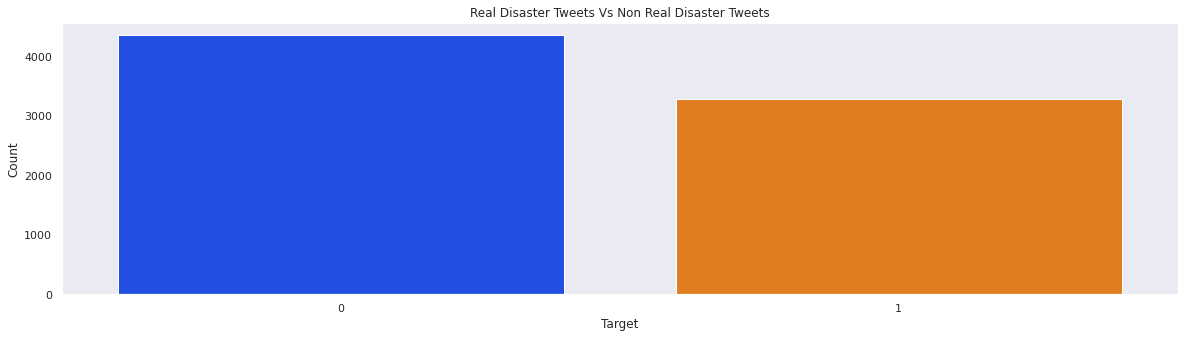

In [13]:
# Plot Count: Real Disaster Tweets Vs Non Real Disaster Tweets
sns.countplot(x='target', data=df)
plt.title('Real Disaster Tweets Vs Non Real Disaster Tweets')
plt.ylabel('Count')
plt.xlabel('Target')
plt.show()

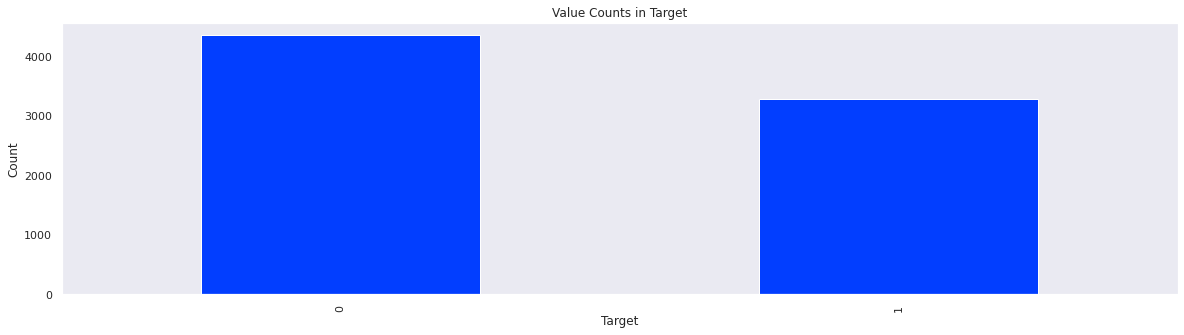

In [14]:
# Return counts of unique values within target feature.
df['target'].value_counts().plot.bar()
plt.title('Value Counts in Target')
plt.ylabel('Count')
plt.xlabel('Target')
plt.show()

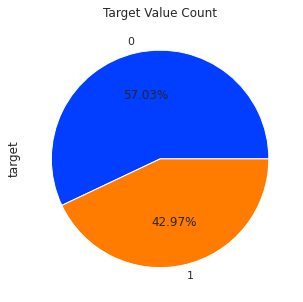

In [15]:
# Generate a pie plot for target feature.
df['target'].value_counts().plot.pie(autopct='%1.2f%%')
plt.title('Target Value Count')
plt.show()

### Distribution in Tweets 


In [16]:
# Useful agregations from tweets 
df = kgp.get_basic_features(df)
df.head()

,id,keyword,location,text,target,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,57,13,4.384615,6,1,0,0,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,32,7,4.571429,0,0,0,1,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,112,22,5.090909,9,0,0,1,0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,57,8,7.125000,1,1,0,1,0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,72,16,4.500000,6,2,0,0,0


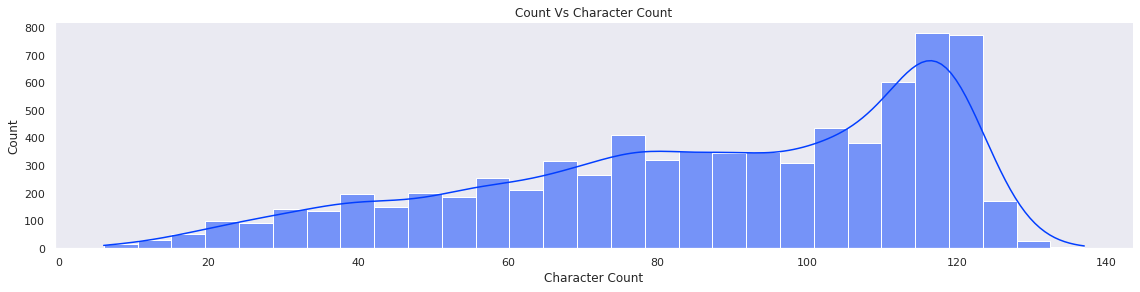

In [17]:
# Plot density distribution of a char_counts feature
sns.displot(df['char_counts'], height=4, aspect=4, kde=True)
plt.title('Count Vs Character Count')
plt.ylabel('Count')
plt.xlabel('Character Count')
plt.show()

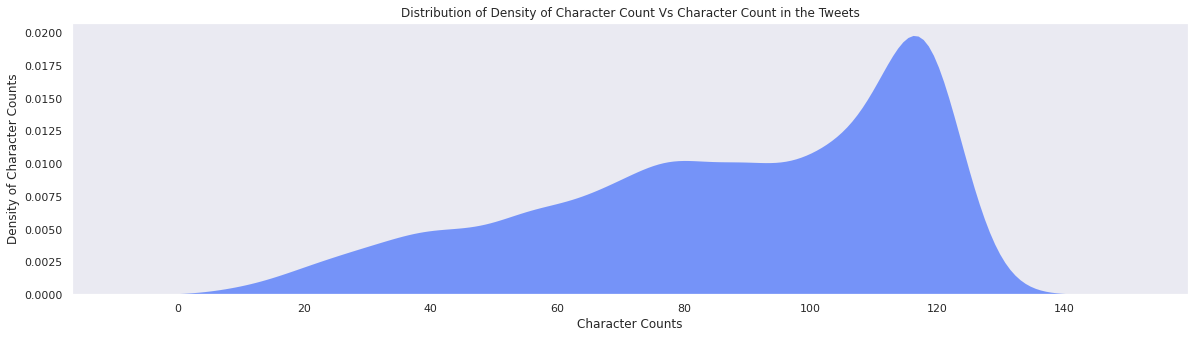

In [18]:
# Plot Kernel Density Estimate (KDE) Plot for char_counts
sns.kdeplot(df['char_counts'], shade=True, fill=True, alpha=.5, linewidth=0)
plt.title('Distribution of Density of Character Count Vs Character Count in the Tweets')
plt.ylabel('Density of Character Counts')
plt.xlabel('Character Counts')
plt.show()

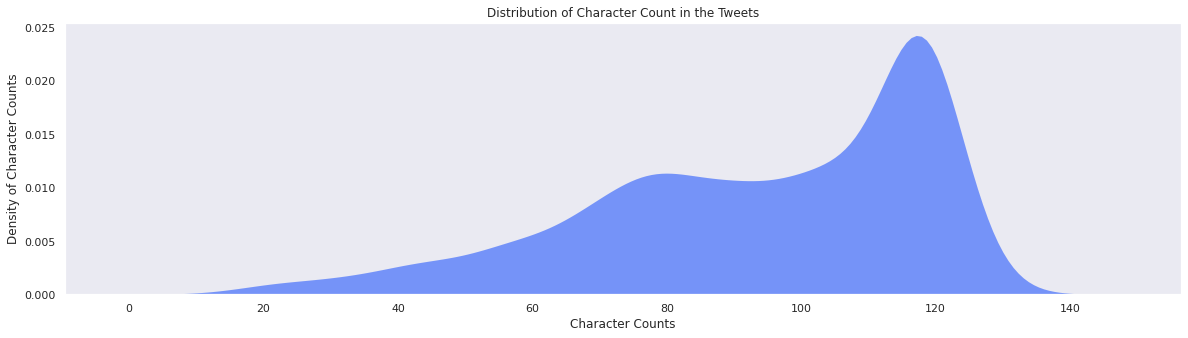

In [19]:
# Plot: Kernel Density Estimate (KDE) Plot for char_counts where target == 1
sns.kdeplot(df[df['target'] == 1]['char_counts'], shade=True, fill=True, alpha=.5, linewidth=0)
plt.title('Distribution of Character Count in the Tweets')
plt.ylabel('Density of Character Counts')
plt.xlabel('Character Counts')
plt.show()

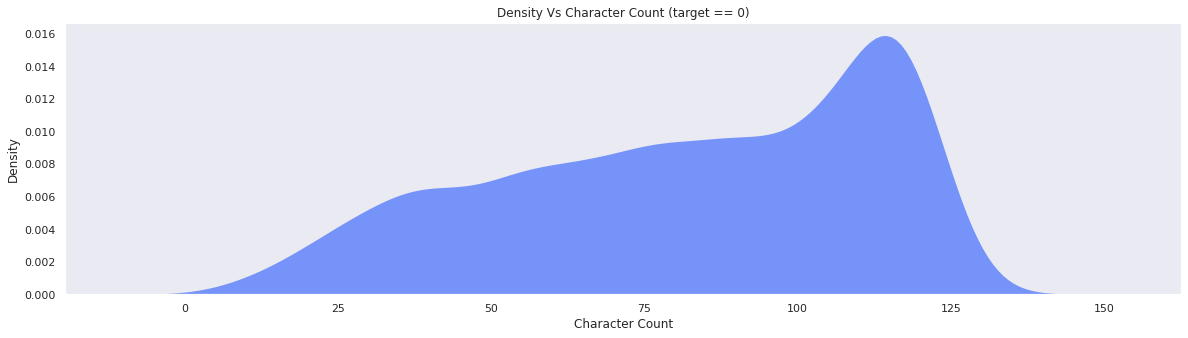

In [20]:
# Plot: Kernel Density Estimate (KDE) Plot for char_counts where target == 0
sns.kdeplot(df[df['target'] == 0]['char_counts'], shade=True, fill=True, alpha=.5, linewidth=0)
plt.title('Density Vs Character Count (target == 0)')
plt.ylabel('Density')
plt.xlabel('Character Count')
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


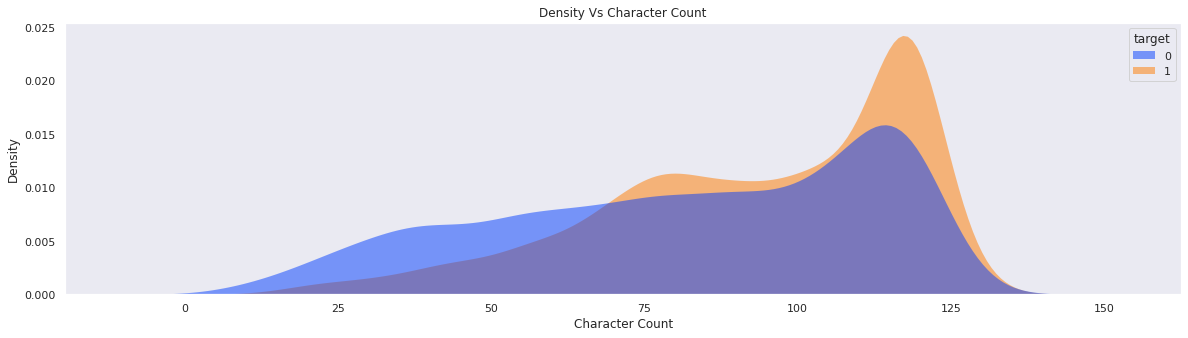

In [21]:
# Kernel Density Estimate (KDE) Plot for char_counts where target == 0 and where target == 1
sns.kdeplot(df[df['target'] == 1]['char_counts'], shade=True, color='red', hue=df['target'], fill=True, alpha=.5, linewidth=0)
sns.kdeplot(df[df['target'] == 0]['char_counts'], shade=True, color='blue', hue=df['target'], fill=True, alpha=.5, linewidth=0)
plt.title('Density Vs Character Count')
plt.ylabel('Density')
plt.xlabel('Character Count')
plt.show()

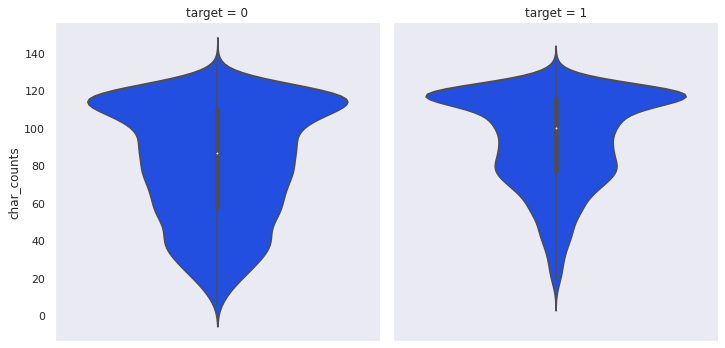

In [22]:
# Plot catplot
sns.catplot(y='char_counts', data=df, kind='violin', col='target')
plt.show()

### Number of Words, Average Words Length, and Stop Words Distribution in Tweets

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


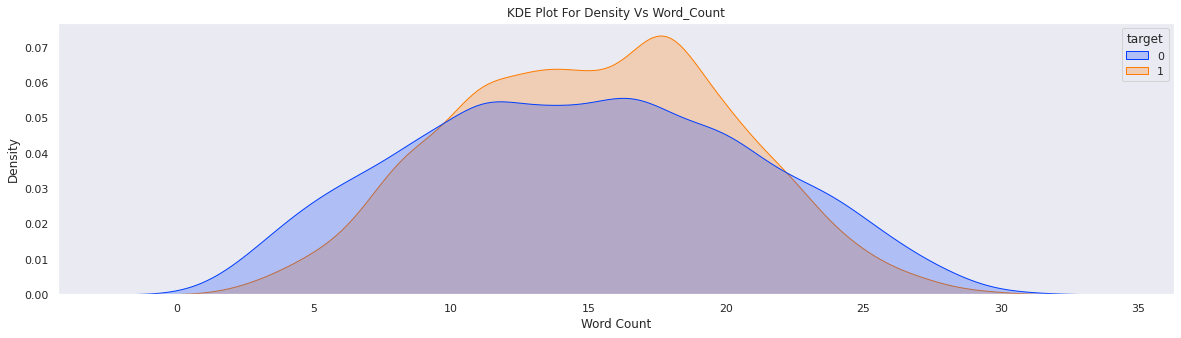

In [23]:
# Plot: Kernel Density Estimate (KDE) Plot for word_counts where target == 0 and where target == 1
sns.kdeplot(df[df['target'] == 1]['word_counts'], shade=True, color='red', hue=df['target'])
sns.kdeplot(df[df['target'] == 0]['word_counts'], shade=True, color='blue', hue=df['target'])
plt.title('KDE Plot For Density Vs Word_Count')
plt.ylabel('Density')
plt.xlabel('Word Count')
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


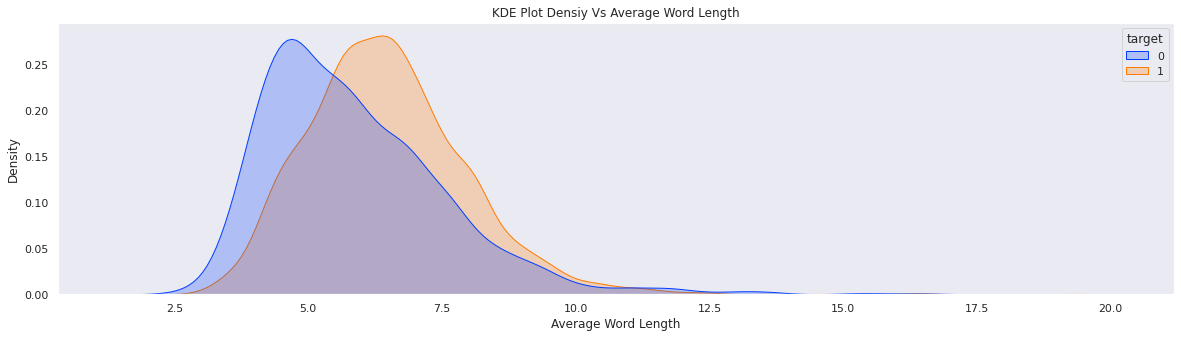

In [24]:
# Plot: Kernel Density Estimate (KDE) Plot for avg_wordlength where target == 0 and where target == 1
sns.kdeplot(df[df['target'] == 1]['avg_wordlength'], shade=True, color='red', hue=df['target'])
sns.kdeplot(df[df['target'] == 0]['avg_wordlength'], shade=True, color='blue', hue=df['target'])
plt.title('KDE Plot Densiy Vs Average Word Length')
plt.ylabel('Density')
plt.xlabel('Average Word Length')
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


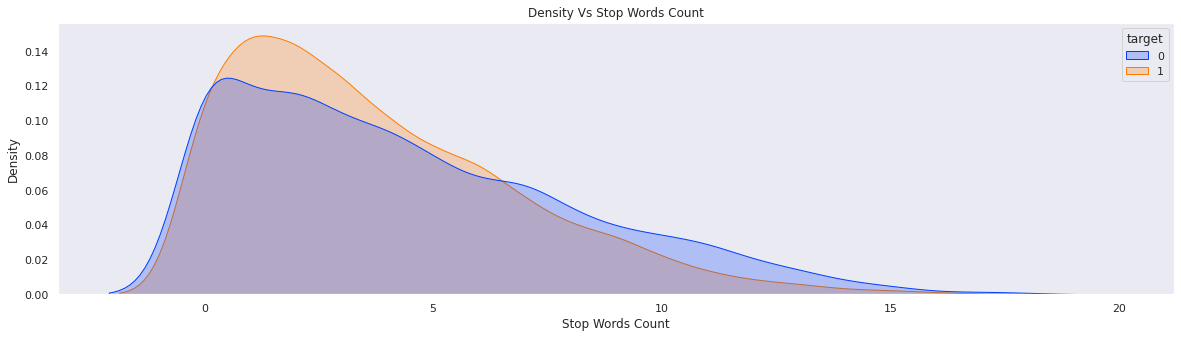

In [25]:
# PLot: Kernel Density Estimate (KDE) Plot for stopwords_counts_count where target == 0 and where target == 1
sns.kdeplot(df[df['target'] == 1]['stopwords_counts'], shade=True, color='red', hue=df['target'])
sns.kdeplot(df[df['target'] == 0]['stopwords_counts'], shade=True, color='blue', hue=df['target'])
plt.title('Density Vs Stop Words Count')
plt.ylabel('Density')
plt.xlabel('Stop Words Count')
plt.show()

# Data Exploration with N-Grams

### Frequency of Words (unigram)

In [26]:
# frequency of Words (unigram)
unigram_freq = kgp.get_word_freqs(df=df, col='text')
unigram_freq.shape

(31924,)

### Common Top 20 Unigram (one word)

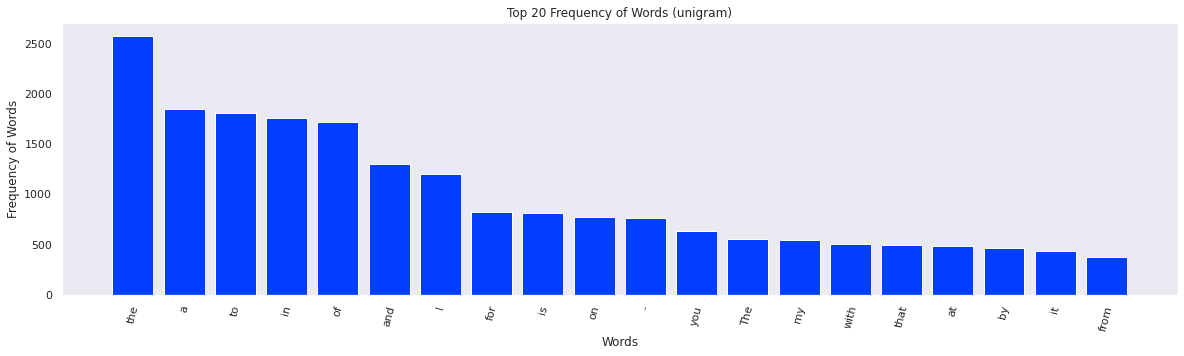

In [27]:
# 20 Top Words (unigram)
top_20_unigram_freq = unigram_freq[:20]

# Plot top_20_unigram_freq Index Vs top_20_unigram_freq Values
plt.bar(top_20_unigram_freq.index, top_20_unigram_freq.values)
plt.xticks(rotation = 75)
plt.title("Top 20 Frequency of Words (unigram)")
plt.ylabel('Frequency of Words')
plt.xlabel('Words')
plt.show()

### Unigram (one word) - Least Used Common Words (Last 20 Words in the unigram_freqs)

In [28]:
# Last 20 Words in the unigram_freqs (unigram)
least_20_unigram_freq = unigram_freq[-20:]
least_20_unigram_freq

windstorm'.                1
Alive.                     1
@bmurph1019                1
#CanonTattoo               1
represents                 1
https://t.co/B0ZJWgmaIW    1
condemnation               1
roses                      1
@TNeazzy                   1
Superb                     1
vivid                      1
occupational               1
http://t.co/iM2HdsKlq5     1
AÛ_                       1
@JMCwrites                 1
https://t.co/T07qxP5cBE    1
gwatt                      1
http://t.co/2o7Eva1cOe     1
http://t.co/he7Q7H3nZf     1
't                         1
dtype: int64

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 137 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 137 missing from current font.
  font.set_text(s, 0, flags=flags)


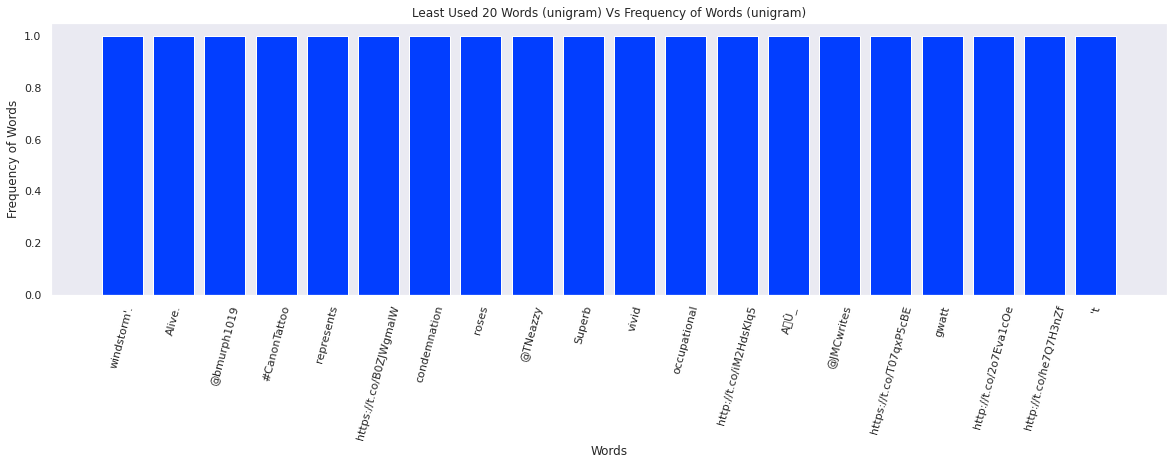

In [29]:
# Plot least_20_unigram_freq Index Vs least_20_freq_unigram_words Values
plt.bar(least_20_unigram_freq.index, least_20_unigram_freq.values)
plt.xticks(rotation = 75)
plt.title("Least Used 20 Words (unigram) Vs Frequency of Words (unigram)")
plt.ylabel('Frequency of Words')
plt.xlabel('Words')
plt.show()

### Bi-gram Tweet Analysis

In [30]:
bi_gram_freq = kgp.get_ngram(df=df, col='text', ngram_range=2)

# Common Top 20 Bi-gram (two words)
top_20_bi_gram_freq = bi_gram_freq[:20]
top_20_bi_gram_freq

[('ûówe work', 68495),
 ('ûótech business', 68494),
 ('ûónegligence and', 68493),
 ('ûókody vine', 68492),
 ('ûóher upper', 68491),
 ('ûó wallybaiter', 68490),
 ('ûó the', 68489),
 ('ûó stories', 68488),
 ('ûó rt', 68487),
 ('ûó richmond', 68486),
 ('ûó organizers', 68485),
 ('ûó oh', 68484),
 ('ûó now', 68483),
 ('ûó lol', 68482),
 ('ûó integrates', 68481),
 ('ûó https', 68480),
 ('ûó hiroshima', 68479),
 ('ûó head', 68478),
 ('ûó eh', 68477),
 ('ûó desolation', 68476)]

# Data Cleaning

In [31]:
# Function to clean tweets data
def get_clean(x):
    x = str(x).lower().replace('\\', '').replace('_', ' ').replace('.', ' ')
    x = kgp.cont_exp(x)
    x = kgp.remove_emails(x)
    x = kgp.remove_urls(x)
    x = kgp.remove_html_tags(x)
    x = kgp.remove_rt(x)
    x = kgp.remove_accented_chars(x)
    x = kgp.remove_special_chars(x)
    x = re.sub("(.)\\1{2,}", "\\1", x)
    return x

In [32]:
df['text'] = df['text'].apply(lambda x: get_clean(x))
df.head()

,id,keyword,location,text,target,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1,57,13,4.384615,6,1,0,0,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1,32,7,4.571429,0,0,0,1,0
2,5,NaN,NaN,all residents asked to shelter in place are be...,1,112,22,5.090909,9,0,0,1,0
3,6,NaN,NaN,130 people receive wildfires evacuation orders...,1,57,8,7.125000,1,1,0,1,0
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1,72,16,4.500000,6,2,0,0,0


# Tweet Visualisation - Real Disaster Tweets

In [33]:
real_disaster_tweets = kgp.get_word_freqs(df=df[df["target"]==1], col="text")
real_disaster_tweets = " ".join(real_disaster_tweets.index)
real_disaster_tweets

'httpt the in of a to and is on for i at by from it that with not you after this fire was are as have my news httpst over up more via disaster an were be people california suicide no has police who but when been killed like do will 2 just hiroshima than so fires out storm crash families we train now about into s emergency your buildings bomb there all what two mh370 attack nuclear am they wildfire video accident get bombing new one northern burning minister prime how dead legionnaires me bomber if homes some war car still atomic obama fatal he years off may forest us collapse watch retweet city debris 1 japan first malaysia today or mass man latest water severe near had those earthquake confirmed before found oil would spill 70 world army down floods home under warning could 3 injured weather outbreak 4 evacuation wreckage derailment saudi being thunderstorm 40 migrants our old say missing flooding can investigators flood during time their bridge death mosque her suspect state back u k

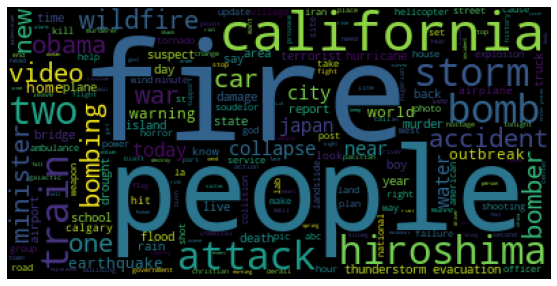

In [34]:
# Create WordCloud instance word_cloud
word_cloud = WordCloud(max_font_size=100)

# Generate word cloud
word_cloud.generate(real_disaster_tweets)

# Plot Words
plt.imshow(word_cloud)
plt.axis("off")
plt.show()

# Tweet Visualisation - Not Real Disaster Tweets

In [35]:
not_real_disaster_tweets = kgp.get_word_freqs(df=df[df["target"] == 0], col="text")
not_real_disaster_tweets = " ".join(not_real_disaster_tweets.index)
not_real_disaster_tweets

'the httpt i a to and of is in you my it for not on that with this have be am httpst are do me out your like so by at just was but will up all he if from new as get they has we or no when now about what would an how one can there body people 2 via her been video his into more loud us love know back time why got off full emergency them after see who day going 3 cannot youtube did still some fire let good go she think want laughing had man ass our should over retweet world then way life first youre their work last burning too need make only really news than because god even being much many here best take content help could right were say 5 him wreck feel black its great today please hot 4 every never look im fucking down 1 fear cross before ever bags read night fuck oh top does these come bag reddit without year another everyone getting any ruin death liked shit may panic screaming head bloody always u smoke bad wrecked most well coming face disaster harm explode buildings crash school w

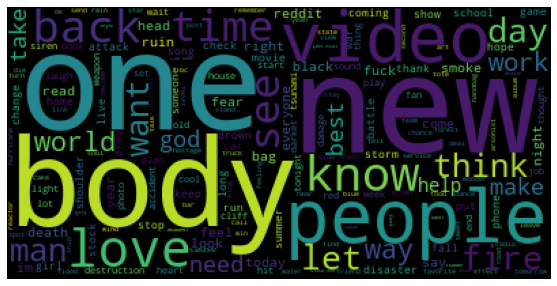

In [36]:
# Create WordCloud instance word_cloud
word_cloud = WordCloud(max_font_size=100)

# Generate word_cloud 
word_cloud.generate(not_real_disaster_tweets)

# Plot Words
plt.imshow(word_cloud)
plt.axis("off")
plt.show()

# Classification with TFIDF and Linear Support Vector Classification (LinearSVC).

In [37]:
# Store text from df into text variable
text = df['text']

# store target in y variable
y = df['target']

In [38]:
# create an instance of TfidfVectorizer(), vectorizer
vectorizer = TfidfVectorizer()

# Convert text to a matrix of TF-IDF features (X).
X = vectorizer.fit_transform(text)

In [39]:
# Type of X
type(X)

scipy.sparse.csr.csr_matrix

In [40]:
# Get shape of X
print(X.shape)

(7613, 22546)


In [41]:
print(vectorizer.get_feature_names()[0:11])


['00', '0011', '0016', '0025', '005225', '00end', '01', '010156', '010217', '0104', '010401']


In [42]:
# Split  X and y  into random train and test subsets, (X_train, y_train, X_test, y_test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7, stratify=y)

In [43]:
# Create function run_SVM to train and predict and print classification_report
def run_svm(clf, X_train, X_test, y_train, y_test):

  # train instance of SVM (clf)
  clf.fit(X_train, y_train)

  #  Use trained clf to predict on X_test
  y_pred = clf.predict(X_test)

  print()

  # print classification report
  print ('Classification Report')
  print(classification_report(y_test, y_pred))

In [44]:
# create an instance of LinearSVC as clf
clf = LinearSVC ()

# train the clf using run_svm
run_svm(clf, X_train, X_test, y_train, y_test)  


Classification Report
              precision    recall  f1-score   support

           0       0.78      0.87      0.82      1303
           1       0.79      0.68      0.73       981

    accuracy                           0.79      2284
   macro avg       0.79      0.77      0.78      2284
weighted avg       0.79      0.79      0.78      2284



# Classification with Word2Vec and SVM

In [45]:
# create nlp object using load method from en_core_web_lg
nlp = en_core_web_lg.load()

In [46]:
# create function get_vector
def get_vec(x):
  doc=nlp(x)
  vec = doc.vector
  return vec

In [47]:
# create a vector feature using get_vec function
df['vec'] = df['text'].apply(lambda x: get_vec(x))

In [48]:
# quick check of df
df.head()

,id,keyword,location,text,target,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts,vec
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1,57,13,4.384615,6,1,0,0,1,"[-0.26623327, 0.05843069, -0.1404636, -0.05265..."
1,4,NaN,NaN,forest fire near la ronge sask canada,1,32,7,4.571429,0,0,0,1,0,"[-0.014817425, -0.09212343, -0.10716944, -0.33..."
2,5,NaN,NaN,all residents asked to shelter in place are be...,1,112,22,5.090909,9,0,0,1,0,"[0.0059339865, 0.016337818, -0.105279535, -0.0..."
3,6,NaN,NaN,130 people receive wildfires evacuation orders...,1,57,8,7.125000,1,1,0,1,0,"[-0.13400537, 0.25267026, 0.09032763, -0.16645..."
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1,72,16,4.500000,6,2,0,0,0,"[-0.06394094, -0.01423019, 0.0063574947, 0.071..."


In [49]:
# convert vec feature into nnumpy array
X = df['vec'].to_numpy()

# print number of dimensions of X
print("Dimension of X is {} " .format(X.ndim))

# print shape of X
print("Shape of X is {} " .format(X.shape))

Dimension of X is 1 
Shape of X is (7613,) 


In [50]:
# reshape X
X = X.reshape(-1, 1)

# print shape of X
print("Shape of X is {} " .format(X.shape))


Shape of X is (7613, 1) 


In [51]:
#  Join a sequence of arrays X,  along an axis = 0
X = np.concatenate(np.concatenate(X, axis=0), axis=0).reshape(-1, 300)

In [52]:
# print X
X.shape

(7613, 300)

In [53]:
# Split  X and y  into random train and test subsets, (X_train, y_train, X_test, y_test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7, stratify=y)

In [54]:
# create an instance of LinearSVC as clf
clf = LinearSVC ()

# train the clf using run_svm
run_svm(clf, X_train, X_test, y_train, y_test)


Classification Report
              precision    recall  f1-score   support

           0       0.79      0.86      0.82      1303
           1       0.79      0.71      0.74       981

    accuracy                           0.79      2284
   macro avg       0.79      0.78      0.78      2284
weighted avg       0.79      0.79      0.79      2284



# Word Embeddings and Classification with Deep Learning

In [55]:
# create an instance of text tokenization utility class, tokenizer from Tokenizer()
tokenizer  = Tokenizer()
tokenizer.fit_on_texts(text)

# Get vocabulary size of tokenizer 
vocabulary_size  = len(tokenizer.word_index) + 1

# print vocabulary of vocabulary_size 
print("Vocabulary size is {}".format(vocabulary_size ))

Vocabulary size is 22582


In [56]:
  # print word_index of the tokenizer 
  # print(tokenizer.word_index)

In [57]:
def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

In [58]:
first_10_items = take(10, tokenizer.word_index.items())
print(first_10_items)


[('httpt', 1), ('the', 2), ('a', 3), ('in', 4), ('to', 5), ('of', 6), ('i', 7), ('and', 8), ('is', 9), ('you', 10)]


In [59]:
# Transform each text in texts to a sequence of integers.
sequences = tokenizer.texts_to_sequences(text)
print(sequences)

[[109, 4491, 22, 2, 868, 6, 20, 246, 129, 1681, 4492, 74, 41], [186, 43, 223, 763, 6792, 6793, 1328], [41, 1682, 1435, 5, 2062, 4, 655, 22, 125, 6794, 19, 1683, 42, 438, 253, 58, 2062, 4, 655, 1329, 22, 1054], [2809, 56, 4493, 1330, 253, 1329, 4, 86], [36, 93, 1159, 20, 314, 23, 6795, 2063, 29, 261, 23, 1330, 6796, 68, 3, 189], [2810, 391, 86, 1554, 793, 829, 4, 637, 6797, 534, 5, 1106, 371, 43, 4494, 1330], [224, 73, 830, 282, 1160, 831, 247, 6, 1862, 4, 6798, 999, 2344, 1555], [7, 31, 12, 225, 6, 2, 1863, 8, 7, 71, 103, 3, 43, 4, 2, 4495], [62, 9, 44, 72, 253, 1237, 52, 4, 2, 585, 832, 2, 703], [7, 31, 2345, 16, 2, 489, 9, 240, 5, 109, 354], [586, 56, 611, 23, 2, 283, 467, 32, 612], [833, 613, 2811, 9, 217, 2812, 3467, 656, 3, 657, 7, 199, 4, 613, 2811, 57, 31, 7, 301, 27, 57, 31, 7, 301, 27, 6799, 247], [2813, 247, 2064, 6800, 2811, 1436, 58, 1864, 614, 7, 21, 735, 3468], [224, 4, 4496, 912, 49, 1684, 4496], [241, 5, 189, 392, 12, 2346, 4, 4497, 126, 87, 355], [638, 34, 96], [7, 110

In [60]:

# Set maximum length of all sequences = 40
maximum_length = 40

# Transform sequences (lists of integers) into a 2D Numpy array of shape
X = pad_sequences(sequences, maxlen= maximum_length, padding='post') 
print(X.shape)

(7613, 40)


In [61]:
# check X
X

array([[ 109, 4491,   22, ...,    0,    0,    0],
       [ 186,   43,  223, ...,    0,    0,    0],
       [  41, 1682, 1435, ...,    0,    0,    0],
       ...,
       [2709, 2295, 4483, ...,    0,    0,    0],
       [  75, 1092,   39, ...,    0,    0,    0],
       [   2,  206,   55, ...,    0,    0,    0]], dtype=int32)

In [62]:
# Split  X and y  into random train and test subsets, (X_train, y_train, X_test, y_test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7, stratify=y)

In [63]:
vector_size = 100

# create a Sequential model (model) incrementally via the add() method:
model = Sequential()
model.add(Embedding(vocabulary_size, vector_size, input_length=maximum_length))

model.add(Conv1D(32, 2, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(16, activation='relu'))

model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))

In [64]:
# print summary of model

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 100)           2258200   
_________________________________________________________________
conv1d (Conv1D)              (None, 39, 32)            6432      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 19, 32)            0         
_________________________________________________________________
dropout (Dropout)            (None, 19, 32)            0         
_________________________________________________________________
dense (Dense)                (None, 19, 32)            1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 19, 32)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 19, 16)            5

In [65]:
%%time 
# compile and train the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')
model.fit(X_train, y_train, epochs=7, validation_data=(X_train, y_train))

Epoch 1/7
167/167 [==============================] - 8s 41ms/step - loss: 0.6884 - accuracy: 0.5314 - val_loss: 0.6448 - val_accuracy: 0.7816
Epoch 2/7
167/167 [==============================] - 6s 36ms/step - loss: 0.5470 - accuracy: 0.7432 - val_loss: 0.4226 - val_accuracy: 0.8786
Epoch 3/7
167/167 [==============================] - 6s 36ms/step - loss: 0.3407 - accuracy: 0.8696 - val_loss: 0.3299 - val_accuracy: 0.9187
Epoch 4/7
167/167 [==============================] - 6s 36ms/step - loss: 0.2385 - accuracy: 0.9275 - val_loss: 0.2267 - val_accuracy: 0.9542
Epoch 5/7
167/167 [==============================] - 6s 36ms/step - loss: 0.1594 - accuracy: 0.9503 - val_loss: 0.1840 - val_accuracy: 0.9681
Epoch 6/7
167/167 [==============================] - 6s 36ms/step - loss: 0.1416 - accuracy: 0.9573 - val_loss: 0.1362 - val_accuracy: 0.9754
Epoch 7/7
167/167 [==============================] - 6s 37ms/step - loss: 0.0961 - accuracy: 0.9736 - val_loss: 0.1155 - val_accuracy: 0.9790
CPU ti

In [66]:
# create a function to encode incoming text
def get_encoded_vector(x):
  x = get_clean(x)
  x = tokenizer.texts_to_sequences([x])
  x = pad_sequences(x, maxlen=maximum_length, padding='post')
  return x

In [67]:
# tweet example 
x ="it is a real fire. Send Help Immediately"

# encode incoming text 
encoded_vector = get_encoded_vector(x)
encoded_vector


array([[  13,    9,    3,  381,   43,  527,  164, 3911,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0]], dtype=int32)

In [68]:
# Get prediction
np.argmax(model.predict(encoded_vector), axis = -1)

array([0])

# BERT Model Building and Training

In [69]:
!pip install ktrain


In [70]:
import ktrain
from ktrain import text
(X_train, y_train), (X_test, y_test), preproc = text.texts_from_df(train_df=df, text_column='text', label_columns='target', maxlen=40 , preprocess_mode='bert')

downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


In [71]:
model = text.text_classifier(name='bert', train_data=(X_train, y_train), preproc=preproc)

Is Multi-Label? False
maxlen is 40
done.


In [72]:
learner = ktrain.get_learner(model=model, train_data=(X_train, y_train), val_data=(X_test, y_test), batch_size=64)

In [73]:
learner.fit_onecycle(lr = 2e-5, epochs=1)



begin training using onecycle policy with max lr of 2e-05...
108/108 [==============================] - 3094s 28s/step - loss: 0.5816 - accuracy: 0.7044 - val_loss: 0.4338 - val_accuracy: 0.8110


In [74]:
# find best learning rate to find an excellent learner 
# learner.lr_find()
# learner.lr_plot()

In [75]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [76]:
data = ['she met me today by accident', 'the shop owner had a real accident and he is injured']

In [77]:
predictor.predict(data)

/usr/local/lib/python3.6/dist-packages/ktrain/text/preprocessor.py:216: UserWarning: List or array of two texts supplied, so task being treated as text classification. If this is a sentence pair classification task, please cast to tuple.
  'If this is a sentence pair classification task, please cast to tuple.')


['not_target', 'target']

In [78]:
predictor.get_classes()

['not_target', 'target']

In [80]:
predictor.predict(data, return_proba=True)

/usr/local/lib/python3.6/dist-packages/ktrain/text/preprocessor.py:216: UserWarning: List or array of two texts supplied, so task being treated as text classification. If this is a sentence pair classification task, please cast to tuple.
  'If this is a sentence pair classification task, please cast to tuple.')


array([[0.91320777, 0.08679222],
       [0.11588991, 0.8841101 ]], dtype=float32)

In [81]:
data = "He nearly had an accident today"

In [82]:
predictor.predict(data)

'target'

In [83]:
data = "It was not an accident"

In [84]:
predictor.predict(data)

'not_target'